In [1]:
PART_1_SKIP = False
PART_2_SKIP = False
PART_3_SKIP = True

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb

import os

import zipfile
z = zipfile.ZipFile('Dancer_Images.zip', 'w')

In [3]:
cap = cv2.VideoCapture('dancing_silhouette.mp4')
print(cap.get(cv2.CAP_PROP_FPS))

29.97003017816262


In [4]:
%%time

if PART_1_SKIP == False:
    try:
        if not os.path.exists('data'):
            os.makedirs('data')
    except OSError:
        print ('Error: Creating directory of data')

    currentFrame = 0
    count = 0
    TRAIN_SIZE = 27000
    FRAME_SKIP = 2
    IMG_WIDTH = 96
    IMG_HEIGHT = 64
    IMG_CHANNELS = 1
    X_train = np.zeros((TRAIN_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='float32')
    
    video = cv2.VideoWriter('Simple_Shadow_Dancer_Video.avi',cv2.VideoWriter_fourcc(*"MJPG"), 30, (IMG_WIDTH, IMG_HEIGHT), False)

    while(count < TRAIN_SIZE):
        try:
            ret, frame = cap.read()

            if currentFrame % FRAME_SKIP == 0:
                count += 1
                if count % int(TRAIN_SIZE/10) == 0:
                    print(str((count/TRAIN_SIZE)*100)+"% done")
                # preprocess frames
                img = frame
                img = rgb2gray(img)
                img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
                img[img > 0.2] = 255
                img[img <= 0.2] = 0
                # save frame to zip and new video sample
                name = './data/frame' + str(count) + '.jpg'
                cv2.imwrite(name, img)
                #video.write(gray2rgb(img.astype('uint8')))
                video.write(img.astype('uint8'))
                z.write(name)
                os.remove(name)
                # save image to training set if training directly to part 2
                img = img.astype('float32') / 255.
                X_train[count] = img
        except:
            print('Frame error')
            break
        currentFrame += 1

    print(str(count)+" Frames collected")
    cap.release()
    z.close()
    video.release()

/home/aman/anaconda3/envs/dance/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Frame error
27000 Frames collected
CPU times: user 5min 51s, sys: 4.94 s, total: 5min 56s
Wall time: 6min 27s


In [5]:
import sys
import random
import warnings
from pylab import imshow, show, get_cmap
from tqdm import tqdm
from itertools import chain

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, UpSampling2D, Flatten, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras import backend as k
import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed


Using TensorFlow backend.


In [6]:
if PART_1_SKIP:
    IMG_WIDTH = 96
    IMG_HEIGHT = 64
    IMG_CHANNELS = 1
    INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    TRAIN_PATH = 'data/'
    train_ids = next(os.walk(TRAIN_PATH))[2]
    #l = list(os.listdir(TRAIN_PATH))
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS ), dtype = 'float32')
    missing_count = 0
    print('Getting training images...')
    
    for n, filename in enumerate(tqdm(os.listdir(TRAIN_PATH))):
        PATH = TRAIN_PATH + filename
        try:
            img = imread(PATH)
            img = img.astype('float32') / 255
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
            X_train[n-missing_count] = img
        except:
            print('Problem with %s', PATH)
            missing_count += 1
    print(f'Total missing {missing_count}')
    
else:
    INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    

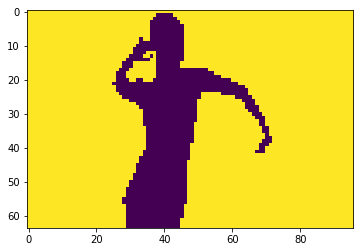

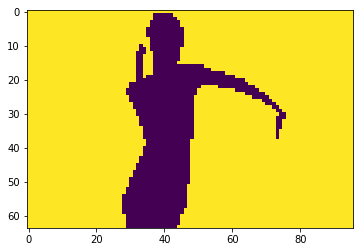

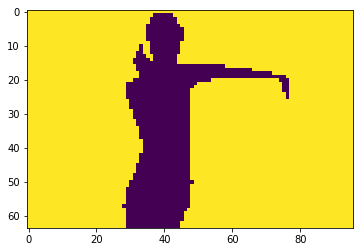

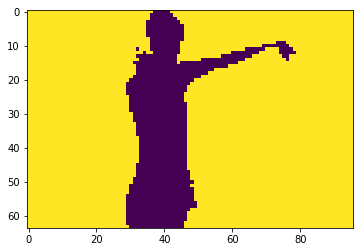

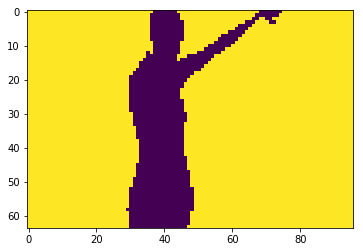

In [7]:
for n in range(10, 15):
    imshow(X_train[n].reshape(IMG_HEIGHT, IMG_WIDTH))
    plt.show()

In [8]:
def Encoder():
    inp = Input(shape=INPUT_SHAPE)
    x = Conv2D(128, (4, 4), activation='elu', padding='same', name='encode1')(inp)
    x = Conv2D(64, (3,3), activation='elu', padding='same', name='encode2')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='encode3')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='encode4')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='encode5')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='encode6')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='encode7')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='encode8')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same', name='encode9')(x)
    x = Flatten()(x)
    x = Dense(256, activation='elu', name='encode10')(x)
    encoded = Dense(128, activation='sigmoid', name='encode11')(x)
    return Model(inp, encoded)
encoder = Encoder()
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 96, 1)         0         
_________________________________________________________________
encode1 (Conv2D)             (None, 64, 96, 128)       2176      
_________________________________________________________________
encode2 (Conv2D)             (None, 64, 96, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 48, 64)        0         
_________________________________________________________________
encode3 (Conv2D)             (None, 32, 48, 64)        36928     
_________________________________________________________________
encode4 (Conv2D)             (None, 32, 48, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 24, 32)        0         
__________

In [9]:
D_INPUT_SHAPE = [ 128 ]
def Decoder():
    inp = Input(shape=D_INPUT_SHAPE, name='decoder')
    x = Dense(256, activation='elu', name='decode1')(inp)
    x = Dense(768, activation='elu', name='decode2')(x)
    x = Reshape((4, 6, 32))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode7')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode8')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode9')(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode10')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode11')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode12')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same', name='decode13')(x)
    x = Conv2D(16, (2, 2), activation='elu', padding='same', name='decode14')(x)
    decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same', name='decode15')(x)
    return Model(inp, decoded)

decoder = Decoder()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder (InputLayer)         (None, 128)               0         
_________________________________________________________________
decode1 (Dense)              (None, 256)               33024     
_________________________________________________________________
decode2 (Dense)              (None, 768)               197376    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 6, 32)          0         
_________________________________________________________________
decode3 (Conv2D)             (None, 4, 6, 32)          4128      
_________________________________________________________________
decode4 (Conv2D)             (None, 4, 6, 64)          18496     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 12, 64)         0         
__________

In [10]:
def Autoencoder():
    inp = Input(shape=INPUT_SHAPE)
    x = Conv2D(128, (4, 4), activation='elu', padding='same',name='encode1')(inp)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode2')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode3')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode4')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode5')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode6')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode7')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode8')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',name='encode9')(x)
    x = Flatten()(x)
    x = Dense(256, activation='elu',name='encode10')(x)
    encoded = Dense(128, activation='sigmoid',name='encode11')(x)
    x = Dense(256, activation='elu', name='decode1')(encoded)
    x = Dense(768, activation='elu', name='decode2')(x)
    x = Reshape((4, 6, 32))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode7')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode8')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode9')(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode10')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode11')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode12')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same', name='decode13')(x)
    x = Conv2D(16, (2, 2), activation='elu', padding='same', name='decode14')(x)
    decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same', name='decode15')(x)
    return Model(inp, decoded)

model = Autoencoder()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 96, 1)         0         
_________________________________________________________________
encode1 (Conv2D)             (None, 64, 96, 128)       2176      
_________________________________________________________________
encode2 (Conv2D)             (None, 64, 96, 64)        73792     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 48, 64)        0         
_________________________________________________________________
encode3 (Conv2D)             (None, 32, 48, 64)        36928     
_________________________________________________________________
encode4 (Conv2D)             (None, 32, 48, 32)        8224      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 24, 32)        0         
__________

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.5, min_lr=0.00001)
checkpoint = ModelCheckpoint('Auto_Model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='min', restore_best_weights=True)

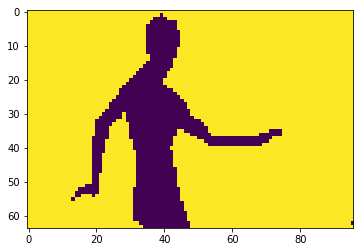

In [18]:
class ImgSample(Callback):
    
    def __init__(self):
        super(Callback, self).__init__()
        
    def on_epoch_end(self, epoch, logs={}):
        sample_img = X_train[50]
        sample_img = sample_img.reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)
        sample_img = self.model.predict(sample_img)[0]
        imshow(sample_img.reshape(IMG_HEIGHT, IMG_WIDTH))
        plt.show()
        
        
imgsample = ImgSample()
model_callbacks = [learning_rate_reduction, checkpoint, early_stopping, imgsample]
imshow(X_train[50].reshape(IMG_HEIGHT, IMG_WIDTH))

In [19]:
%%time
if PART_2_SKIP == False:
    model.fit(X_train, X_train, epochs=30, batch_size=32, verbose=2, validation_split=0.05, callbacks=model_callbacks)
else:
    model = load_model('../input/Auto_Model.hdf5')
    model.load_weights('../input/Auto_Weights.hdf5')

Train on 25650 samples, validate on 1350 samples
Epoch 1/30


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node encode1_1/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/encode1_1/convolution_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/encode1_1/convolution_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, encode1_1/kernel/read)]]
	 [[{{node loss/mul/_563}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2872_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [14]:
X_train

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 